# Intro to DSP

In this seminar we will learn the basics of audio processing for `Deep Learning`

In the end, we will build and train neural network for spoken digit classification (aka AudioMNIST).

In [2]:
!pip install torchaudio==0.8.0

     |████████████████████████████████| 1.9MB 8.8MB/s 
     |████████████████████████████████| 735.5MB 25kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.8.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.8.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [3]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio

import numpy as np

In [4]:
assert torch.__version__.startswith('1.8'), 'Please, install torch>=1.8'
assert torchaudio.__version__.startswith('0.8'), 'Please, install torchaudio>=0.8'

First of all, we will start by loading some `wav` file.

In [8]:
wav, sr = torchaudio.load('LJ001-0001.wav')

Note that `sr` is the [sample rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Sampling_rate) encoded in `LJ001-0001.wav`

In [9]:
sr

22050

Let's take a close look at `wave`. This is a sequence of aplitudes in the range `[-1, 1]` of type `float32 (32 bits)`

In [10]:
wav

tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
          2.1362e-04,  6.1035e-05]])

In [11]:
wav.dtype

torch.float32

Also note the shape of `wav` --`[1, 212893]`. The first dimension means [number of channels](https://en.wikipedia.org/wiki/Multichannel_audio).

For example, mono sound has 1 channel, and stereo sound has 2 channels.

In [12]:
wav.shape

torch.Size([1, 212893])

Finally, let's see and hear that audio

In [13]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

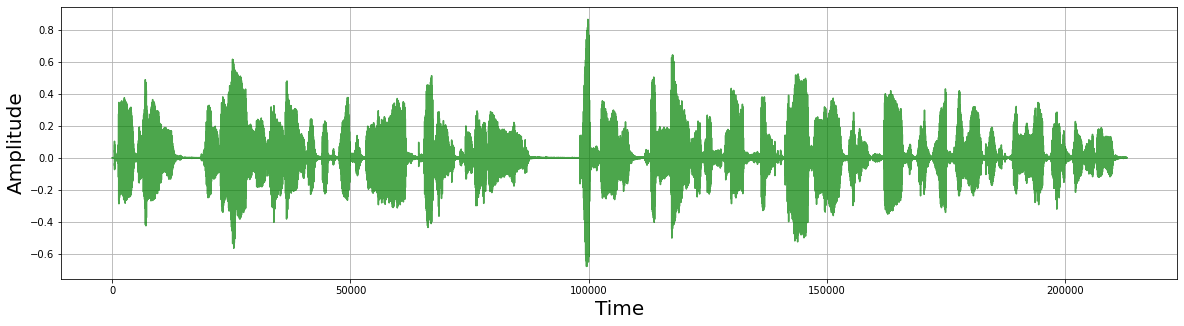

In [14]:
visualize_audio(wav)

Note that we will assume that shape of input for any function is `[1, *]`, e.i batch size equal to 1

Now, let's look at [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (Fast Fourier Transform)

In [15]:
n_fft = 1024

We take the first `1024` samples and transform them. Since our signal is real, we will use `rfft` and the size of the output spectrum will be `n_fft // 2 + 1`.

In [16]:
spectrum = torch.fft.rfft(wav, n=n_fft)

Note that spectrum have `complex` type

In [17]:
spectrum.dtype

torch.complex64

Nextly, we would like to obtain [spectrogram](https://en.wikipedia.org/wiki/Spectrogram). In this case `abs` is [complex modulus](https://en.wikipedia.org/wiki/Complex_modulus)

In [18]:
spectrogram = spectrum.abs().pow(2)

The same result can be obtained as follows:

In [19]:
spectrogram_v2 = torch.view_as_real(spectrum).norm(dim=-1).pow(2)

In [20]:
assert torch.allclose(spectrogram, spectrogram_v2)

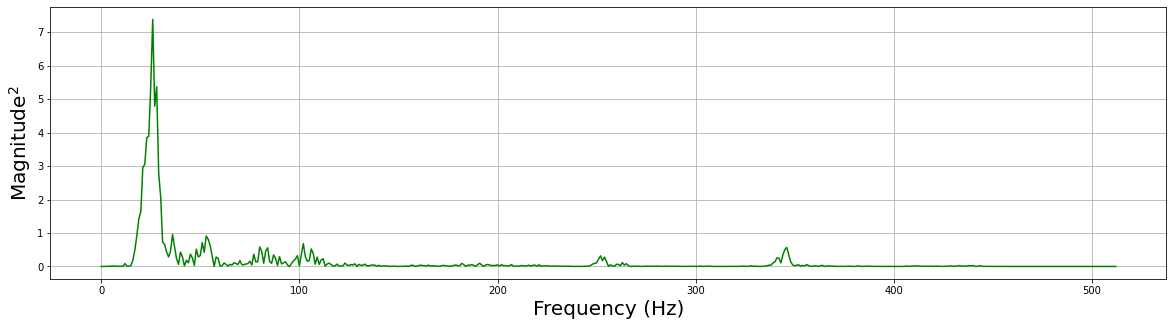

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()

Of course, we don't need to forget about window function. We'll use `Hann` window function.

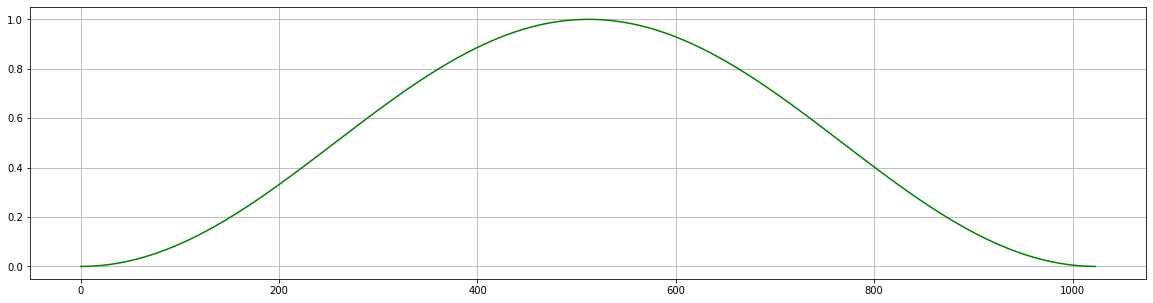

In [22]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()

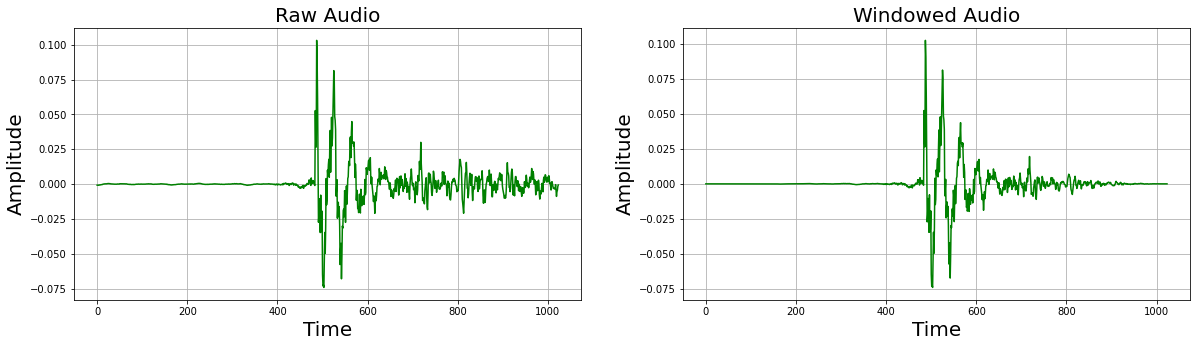

In [23]:
clipped_wav = wav[:, :window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()

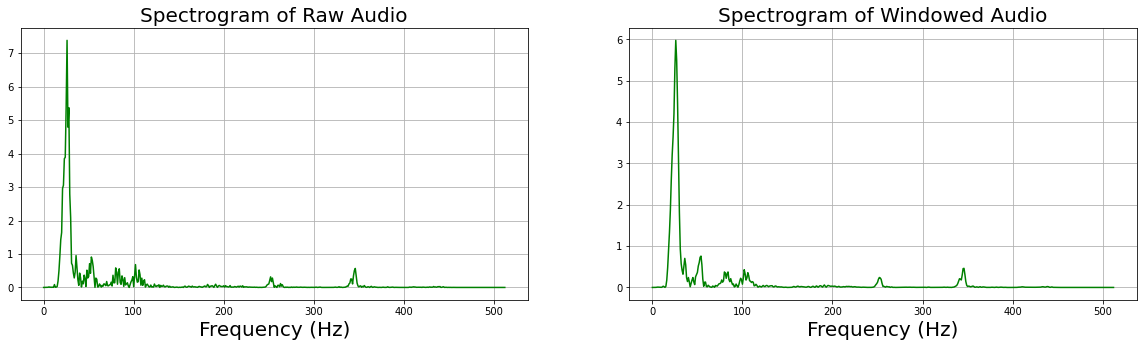

In [24]:
spectrogram = torch.fft.rfft(clipped_wav).abs().pow(2)
windowed_spectrogram = torch.fft.rfft(windowed_clipped_wav).abs().pow(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(spectrogram.squeeze(), c='green')
axes[0].set_title('Spectrogram of Raw Audio', size=20)

axes[1].plot(windowed_spectrogram.squeeze(), c='green')
axes[1].set_title('Spectrogram of Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Frequency (Hz)', size=20)

plt.show()

Let's put it all together and apply [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (Short-time Fourier transform)

In [25]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(n_fft)

In [26]:
spectrum = torch.stft(
    wav,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    
    # We don't want to pad input signal
    center=False,
    
    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,
    
    # Apply torch.view_as_real on each window
    return_complex=False, 
)

In [27]:
spectrum.shape

torch.Size([1, 513, 828, 2])

In [28]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape

torch.Size([1, 513, 828])

The last dimension of spectrogram is time. Each timestamp is called `frame`
Now let's visualize the spectrogram for the whole wav.


Note that to compress the range of spectrogram values, we will apply the element-wise `log`. It is classic spectrogram prepreprocessing.

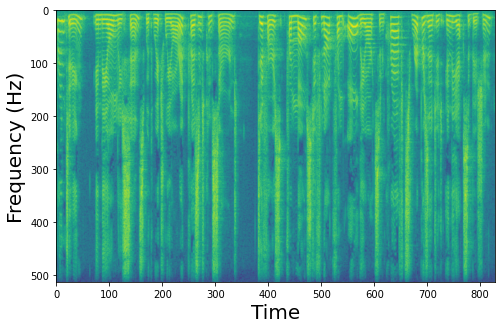

In [29]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

The last stage is `Mel Scale`. First of all, let's take a close look to `Mel Scale` and then apply it to our spectogram.

To initialise `Mel Scale` we will use torchaudio.

In [30]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=22_050,
    n_stft=n_fft // 2 + 1
)

`Mel Scale` is nothing more than rectangle matrix. We will multiply each frame in spectrogram by `mel_scaler.fb` matrix. 

In [31]:
mel_scaler.fb.shape

torch.Size([513, 80])

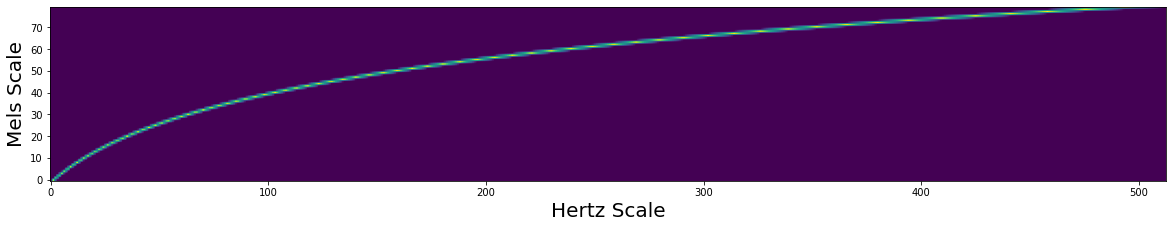

In [32]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel('Hertz Scale', size=20)
plt.ylabel('Mels Scale', size=20)
plt.gca().invert_yaxis()
plt.show()

In [33]:
mel_spectrogram = mel_scaler(spectrogram)

In [34]:
mel_spectrogram.shape

torch.Size([1, 80, 828])

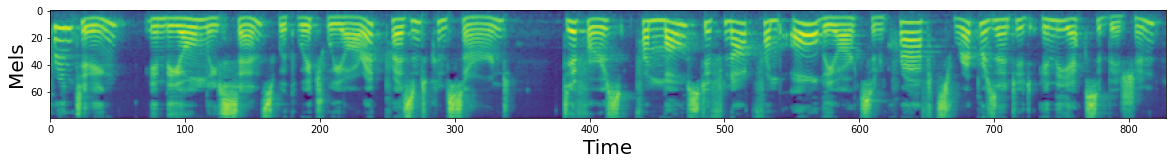

In [35]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In general, we can use `MelSpectrogram` from torchaudio which combine window, stft, spectrogram and mel calculation.

In [36]:
featurizer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22_050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
    window_fn=torch.hann_window,
    center=False
)

In [37]:
assert torch.allclose(mel_spectrogram, featurizer(wav))

# Audio Mnist 

Link to download dataset: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing

You can use `gfile` or download manually from GoogleDrive

In [38]:
import sys
sys.path.append('../')

import gfile

In [39]:
gfile.download_list(
    url='https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06',
    filename='AudioMNIST.zip',
    target_dir='.'
)

It took  2.28sec to download 350.7 MB AudioMNIST.zip 


In [41]:
# !unzip AudioMNIST.zip

The first part of absolutely every machine/deep learning problem is `data preparation`.

In [42]:
from typing import List, Tuple

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

In [43]:
class AudioMnistDataset(Dataset):
    SR = 16_000
    
    """
    Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        
    """
    
    def __init__(self, path_to_data: str):
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('?_*_*.wav'))
    
    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()
        
        # Load wav
        wav, sr = torchaudio.load(path_to_wav)
        
        label = int(path_to_wav.split('/')[-1].split('_')[0])
        
        return wav, label
    
    def __len__(self):
        return len(self.paths)

In [44]:
dataset = AudioMnistDataset('AudioMNIST')

In [45]:
wav, label = dataset[123]
label

5

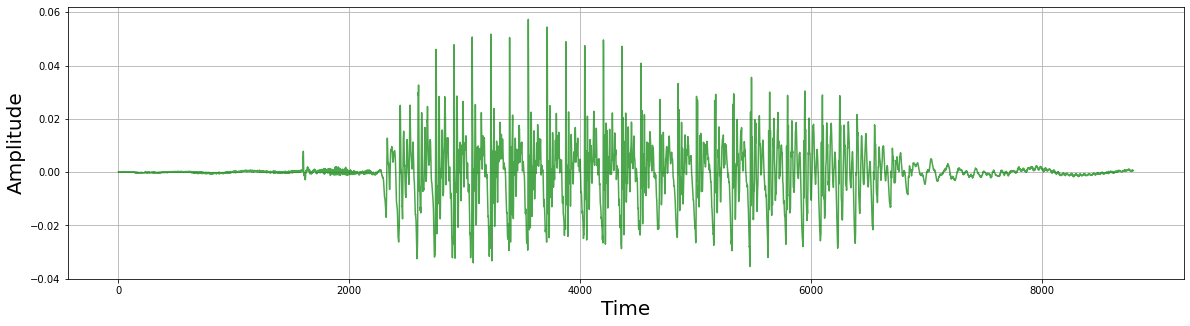

In [46]:
visualize_audio(wav, sr=dataset.SR)

Randomly split dataset on train and validation

In [47]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [48]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

All DL frameworks work with tensors (not lists of tensors). You need to somehow gather audio into a batch, but initially they are of different lengths.

We will apply a simple zero padding.

In [49]:
class Collator:
    
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)
        
        for wav in wavs:
            lengths.append(wav.size(-1))
        
        max_len = max(lengths)
        batch_wavs = torch.zeros(len(batch), max_len)
        for i, (wav, length) in enumerate(zip(wavs, lengths)):
            batch_wavs[i, :length] = wav.squeeze()
            
        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()
        
        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }

In [53]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=32,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

Create class which will process each batch: compute Mel Spectrogram, apply `log` compression and recompute lengths in `frame` scale.

In [54]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=16_000,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram

In [62]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True)
        self.clf = nn.Linear(hidden_size, 10)
    
    def forward(self, input, length=None):
        output, _ = self.rnn(input.transpose(-1, -2))
        
        # Now we want to take the last hidden state of each instance in batch
        # BUT we don't want to take `padding` hidden state
        # We will use `torch.gather` and `length` to dio that
        
        # learn more about gather
        # https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4
        
        last_hidden = torch.gather(
            output,
            dim=1,
            # substract 1 because index start from 0 (not 1 as length)
            index=length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
        )
        
        logits = self.clf(last_hidden.squeeze(dim=1))
        
        return logits

In [75]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=64, hidden_size=128).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [76]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [77]:
storage = defaultdict(list)
num_epoch = 10

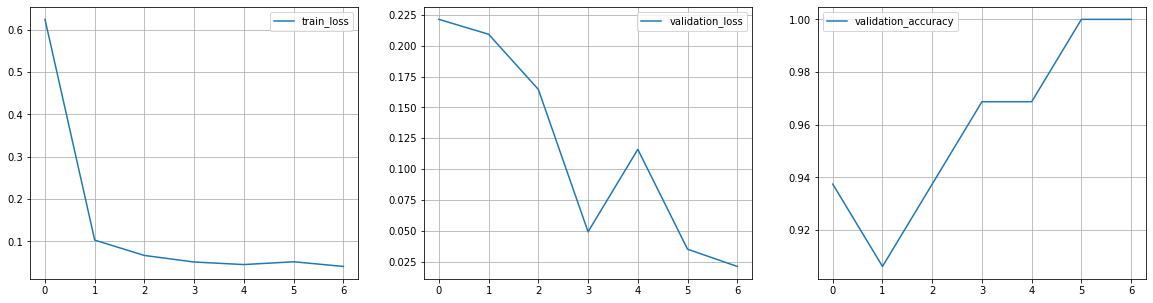


 52%|█████▏    | 442/844 [00:05<00:04, 86.31it/s]Exception in thread Thread-128:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=proces

KeyboardInterrupt: ignored

In [78]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        mel, mel_length = featurizer(wav, length)
        output = model(mel, mel_length)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    display.clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

    